# Vorlesung 5: Wahrscheinlichkeit & Verteilungen
*Zufall formalisieren, einfache Verteilungen verstehen, Unsicherheit sichtbar machen*

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import factorial, exp
import numpy as np
from math import log, exp, lgamma


In [11]:
plt.style.use("seaborn-v0_8-whitegrid")

csv_path = "OECD.WISE.WDP,DSD_HSL@DF_HSL_CWB,+all.csv"
df = pd.read_csv(csv_path, low_memory=False)

unnamed_cols = [c for c in df.columns if "unnamed" in c.lower()]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)

df = df.rename(
    columns={
        "REF_AREA": "country",
        "MEASURE": "measure",
        "UNIT_MEASURE": "unit",
        "TIME_PERIOD": "year",
        "OBS_VALUE": "value",
    }
)

df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["value"] = pd.to_numeric(df["value"], errors="coerce")
for cat_col in ("country", "measure", "unit"):
    if cat_col in df.columns:
        df[cat_col] = df[cat_col].astype("category")

values = df["value"].dropna().to_numpy()
rng = np.random.default_rng(42)


### Hypothese: Wenn wir wiederholt zufällige Stichproben aus den OECD-Werten ziehen, stabilisiert sich der Mittelwert, also zeigt der Datensatz empirisch das Gesetz der großen Zahlen.


In [12]:
# Auswahl der relevanten numerischen Spalte und Entfernung fehlender Werte. Die Werte werden als NumPy-Array gespeichert, damit Stichproben effizient gezogen werden können

s = df["value"].dropna().to_numpy()
len(s), s[:10]


(108088,
 array([68.42857143, 68.42857143, 68.42857143, 68.42857143, 68.42857143,
        68.42857143, 68.42857143, 73.57142857, 73.57142857, 73.57142857]))

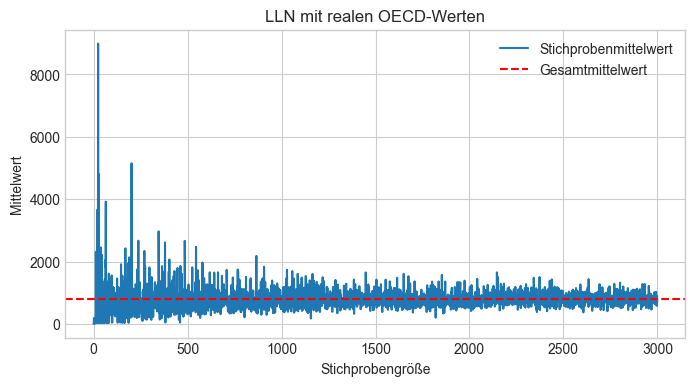

In [13]:
# Gesetz der großen Zahlen (LLN): Laufende Stichprobenmittelwerte sollen sich dem Gesamtmittelwert annähern

rng = np.random.default_rng(42)

running_means = []
N = 3000

for k in range(1, N+1):
    sample = rng.choice(s, size=k, replace=True)
    running_means.append(sample.mean())

plt.figure(figsize=(8,4))
plt.plot(running_means, label="Stichprobenmittelwert")
plt.axhline(np.mean(s), color="red", linestyle="--", label="Gesamtmittelwert")
plt.xlabel("Stichprobengröße")
plt.ylabel("Mittelwert")
plt.title("LLN mit realen OECD-Werten")
plt.legend()
plt.show()


*Kurzinterpretation:*
Die Mittelwerte stabilisieren sich und nähern sich dem Gesamtmittelwert -> Hypothese bestätigt.

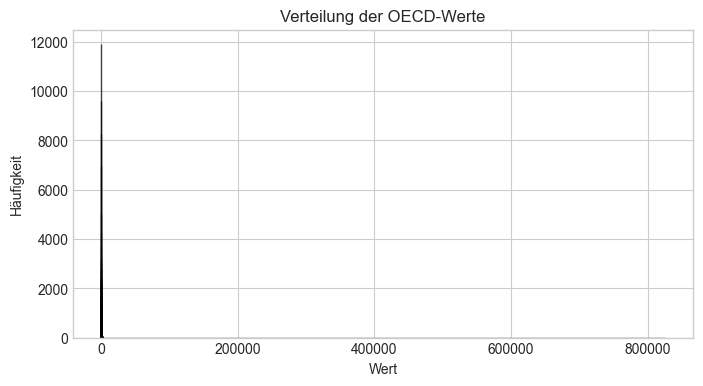

In [14]:
# Verteilung der realen Werte: Darstellung der Form der Verteilung zur Einschätzung von Schiefe und Ausreißern.

plt.figure(figsize=(8,4))
plt.hist(s, bins="fd", edgecolor="black", alpha=0.7)
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der OECD-Werte")
plt.show()



*Kurzinterpretation:* Die Werte sind stark rechtsgeschief → viele kleine Werte, wenige sehr große.


In [15]:
# Mittelwert vs. Varianz: Vergleich zur Einschätzung einer möglichen Poisson-Struktur.

s.mean(), s.var()


(np.float64(796.3451881063945), np.float64(77115604.5196247))

*Kurzinterpretation:* Varianz ist deutlich größer als der Mittelwert → keine Poisson-Verteilung.

/Users/Flurina/Library/CloudStorage/OneDrive-Persönlich/Documents/Uni_St.Gallen/BCS/3.Semester/Statistik_für_Data_Science/Projekt/Statistik-Projekt-OECD-Well-Being/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


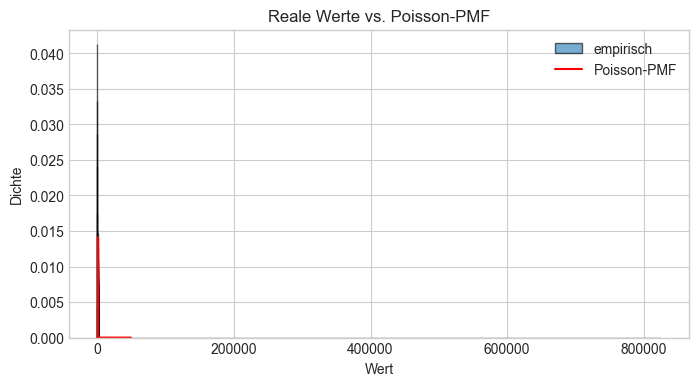

In [16]:
# Vergleich mit theoretischer Poisson-PMF: Vergleich mit theoretischer Poisson-PMF

lam = s.mean()

kmax = int(np.percentile(s, 99.5))
k_vals = np.arange(0, kmax+1)


pmf_pois = np.array([exp(-lam + k*log(lam) - lgamma(k+1)) for k in k_vals])


plt.figure(figsize=(8,4))
plt.hist(s, bins="fd", density=True, alpha=0.6, edgecolor="black", label="empirisch")
plt.plot(k_vals, pmf_pois, color="red", label="Poisson-PMF")
plt.xlabel("Wert")
plt.ylabel("Dichte")
plt.title("Reale Werte vs. Poisson-PMF")
plt.legend()
plt.show()


*Kurzinterpretation:* Die Poisson-Kurve passt nicht zu den realen Werten → Modell ungeeignet.

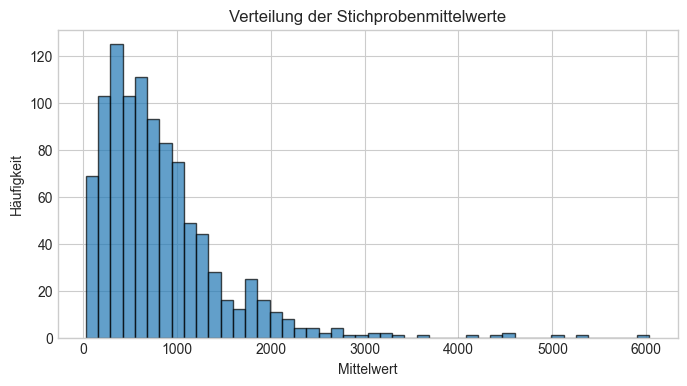

In [17]:
# Verteilung der Stichprobenmittelwerte: Verteilung der Stichprobenmittelwerte

sample_means = [rng.choice(s, size=200, replace=True).mean() for _ in range(1000)]

plt.figure(figsize=(8,4))
plt.hist(sample_means, bins="fd", edgecolor="black", alpha=0.7)
plt.xlabel("Mittelwert")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Stichprobenmittelwerte")
plt.show()


*Kurzinterpretation:* Die Mittelwerte bilden eine engere, glockenähnliche Verteilung.

### Reflexion

In diesem Schritt haben wir die Inhalte aus VL5 auf die tatsächlichen OECD-Werte angewendet. Dabei wurde deutlich, dass die value-Werte eine stark rechtsschiefe Verteilung besitzen: viele kleine Werte, wenige sehr große. Diese Struktur führte dazu, dass einfache theoretische Modelle wie die Poisson-Verteilung nicht zu den Daten passen. Mittelwert und Varianz liegen weit auseinander, und die theoretische Poisson-Kurve stimmt kaum mit der realen Verteilung überein.

Trotz dieser Heterogenität zeigte sich beim Ziehen vieler Zufallsstichproben, dass sich der laufende Mittelwert klar stabilisiert und sich dem Gesamtmittelwert des Datensatzes annähert. Damit lässt sich das Gesetz der großen Zahlen auch in diesen komplexen Echtwerten gut erkennen.
Auffällig war außerdem, dass Stichprobenmittelwerte eine deutlich glattere und stabilere Form annehmen als die ursprünglichen Werte. Dadurch wird sichtbar, dass die starken Unterschiede zwischen Ländern und Jahren zwar die Rohdaten prägen, bei Mittelwerten aber stark abgemildert werden.

Insgesamt zeigt diese Analyse, wie theoretische Wahrscheinlichkeitskonzepte in unseren OECD-Daten sichtbar werden, aber auch, wo einfache Modelle an Grenzen stoßen.